In [1]:
# Interactive Figure
# %matplotlib ipympl 
# Non interactive
%matplotlib inline 

In [2]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qm import SimulationConfig
from qualang_tools.results import fetching_tool
from qualang_tools.loops import from_array
import config_00 as config
import warnings
warnings.filterwarnings("ignore")

2025-05-21 14:56:33,021 - qm - INFO     - Starting session: c640b320-ef1d-40a2-97b2-afda02e3cc66


In [3]:
def addjob(qmprog, qm):
    # Add a QUA program to the OPX queue, which compiles it and executes it
    job = qm.queue.add(qmprog)
    # Wait for job to be loaded
    while job.status=="loading":
        print("Job is loading...")
        time.sleep(0.1)
    # Wait until job is running
    time.sleep(0.1)
    while job.status=="pending":
        q = job.position_in_queue()
        if q>0:
            print("Position in queue",q,end='\r')
        time.sleep(0.1)
    job=job.wait_for_execution()
    print("\nJob is running")
    return job

In [4]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-05-21 14:56:35,926 - qm - INFO     - Performing health check
2025-05-21 14:56:35,934 - qm - INFO     - Health check passed


# Connexion à la Quantum Machine

In [10]:
# Get the QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1690915933853


# Envoyer des pulses et les observer

In [11]:
# This block is using QUA directives which are compiled to the FPGA
chunk_size = 5 # 20ns
IQ_size = config.readout_len//(chunk_size*4)
with program() as prog:
    # Variable declaration
    m = declare(int)
    I = declare(fixed, size=IQ_size)
    Q = declare(fixed, size=IQ_size)
    I_st = declare_stream()
    Q_st = declare_stream()
    # Start measurement
    measure("readout", "scope",
    demod.sliced("cos", I, chunk_size, "out1"),
    demod.sliced("minus_sin", Q, chunk_size, "out1"),
            )
    # Pulse sequence
    play('pulse','qubit',duration=100*u.ns)
    wait(200*u.ns)
    play('pulse','qubit',duration=100*u.ns)
                       
    with for_(m, 0, m < IQ_size, m + 1): 
        save(I[m], I_st)
        save(Q[m], Q_st)

    # Select data to be sent to the client 
    with stream_processing():
        I_st.buffer(IQ_size).save('I')
        Q_st.buffer(IQ_size).save('Q')

In [12]:
# Run the code and fetch results
job = addjob(prog, qm)
res = fetching_tool(job, ['I','Q'])
I, Q = res.fetch_all()
print('Job done')

2025-05-21 15:37:29,568 - qm - INFO     - Sending program to QOP for compilation

Job is running
Job done


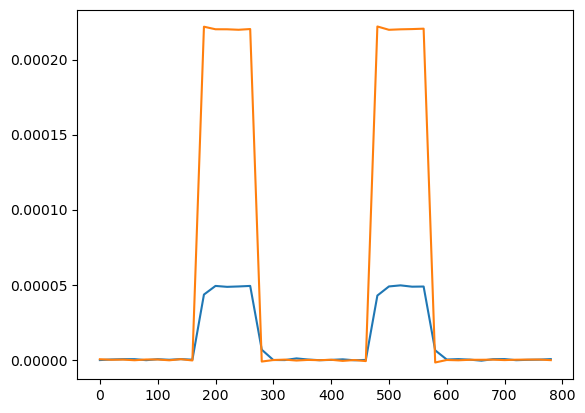

In [13]:
# Plot
t = np.arange(IQ_size)*chunk_size*4
fig,ax=plt.subplots()
ax.plot(t,I,t,Q)

# Exercices
- Lien vers la documentation de Quantum Machines [https://docs.quantum-machines.co/latest/](https://docs.quantum-machines.co/latest/)
- Lire la documentation sur la [démodulation](https://docs.quantum-machines.co/latest/docs/Guides/demod/)

## Exercice 1 : Rotation IQ
- Déphaser la seconde impulsion de $\pi/2$ à l’aide d’une commande [frame_rotation](https://docs.quantum-machines.co/latest/docs/API_references/qua/dsl_main/#for_docs.dsl.frame_rotation). Modifier le délai entre les impulsions : qu’observez-vous ?
- Essayer différents déphasages afin de produire deux impulsions avec des valeurs de $I$ négatives, une impulsion avec un $I$ positif et la seconde avec un $Q$ positif, etc...

## Exercice 2 : Moyennage
- Réduire l’amplitude des deux impulsions d’un facteur 100 en utilisant la commande `amp` à l’intérieur du `play`. Vérifier le résultat.
- Écrire une boucle for pour répéter toute la séquence 1000 fois. Vous devriez obtenir le même tracé qu’auparavant.
- Afin de moyenner sur les répétitions de la boucle, modifier le bloc de traitement des flux (stream processing) comme suit :
  
      with stream_processing():
        I_st.buffer(IQ_size).average().save('I')
        Q_st.buffer(IQ_size).average().save('Q')

  (Lire la documentation sur le [buffering et le moyennage des flux](https://docs.quantum-machines.co/latest/docs/Guides/stream_proc/#using-stream-operators))
- Remplacer une impulsion par une impulsion gaussienne (supprimer le mot-clé `duration`) et observer le résultat
